In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from statsmodels.stats.multitest import multipletests
def bh(p, fdr):
    p_orders = np.argsort(p)
    discoveries = []
    m = float(len(p_orders))
    for k, s in enumerate(p_orders):
        if p[s] <= (k+1) / m * fdr:
            discoveries.append(s)
        else:
            break
    return np.array(discoveries, dtype=int)
    
def bh_predictions(p_values, fdr_threshold):
    reshape = False
    if len(p_values.shape) > 1:
        reshape = True
        p_shape = p_values.shape
        p_values = p_values.flatten()
    pred = np.zeros(len(p_values), dtype=int)
    disc = bh(p_values, fdr_threshold)
    if len(disc) > 0:
        pred[disc] = 1
    if reshape:
        pred = pred.reshape(p_shape)
    return pred

def calc_power(discoveries, beta):
    denom = np.sum([beta != 0])
    nom = 0
    for i, discovery in enumerate(discoveries):
        if discovery == 1 and beta[i] != 0:
            nom += 1
    return nom / float(denom)


def calc_FDR(discoveries, beta):
    denom = np.sum([discoveries != 0])  # changed
    nom = 0
    for i, discovery in enumerate(discoveries):
        if discovery == 1 and beta[i] == 0:
            nom += 1
    if denom == 0:
        return 0
    return nom / float(denom)


# Power analysis

In [85]:
###################### Power to a constant target FDR level #################
from scipy.stats import sem
import pandas as pd
from os import listdir
from os.path import isfile, join
import ast
lw=3.5
th=0.2
fz=36
load = True
dcrt=False
cnt=0; cnt_t=0
thh=0.05
# load = False
is_NN = False #'''TODO: fill in whether you produced NN p-vals or not'''
if load:
    signal_strength=[]
    source = 'C:\\Users\\admin2.EEM-642\\Desktop\\Research\\MRD\\MRD_from_server\\results\\results_non_linear_robustness_020122'#'''TODO: fill in the directory path'''
#     source = 'C:\\Users\\admin2.EEM-642\\Desktop\\Research\\HRT_plus\\results\\non_linear\\results_non_linear_n1000_random_sign_050921'#'''TODO: fill in the directory path'''
    list_files = [join(source, f) for f in listdir(source) if isfile(join(source, f))]
    powers_0 = {}; powers_T = {}; powers_E = {}; powers_ET = {}; powers_NN = {}; powers_NN_T = {}; powers_d = {};
    fdrs_0 = {};fdrs_T = {};fdrs_E = {};fdrs_ET = {};fdrs_NN = {};fdrs_NN_T = {}; fdrs_d = {};
    p_vals_0_dict = {}; p_vals_T_dict = {};
    for file in list_files:
        if not 'csv' in file:
            continue
#         print(file)
        df = pd.read_csv(file)
        cc= df['c'][0]
        c= df['est_rho'][0]
#         if c!=0.16:
#             continue
        if c not in powers_0.keys():
            signal_strength.append(c)
            powers_0[c]=[]; fdrs_0[c]=[]
            powers_T[c]=[]; fdrs_T[c]=[]
            powers_ET[c]=[]; fdrs_ET[c]=[]
            powers_E[c]=[]; fdrs_E[c]=[]
            powers_NN[c]=[]; fdrs_NN[c]=[]
            powers_NN_T[c]=[]; fdrs_NN_T[c]=[]
            powers_d[c]=[]; fdrs_d[c]=[]
            p_vals_0_dict[c] = []
            p_vals_T_dict[c] = []
        ones=df['ones'][0].replace('\n',',').replace('.',',').replace(',,',',')
        ones=np.array(ast.literal_eval(ones))
        if "NN" in file:
            if not is_NN:
              continue
            p_vals_NN = ast.literal_eval(df['p_vals_NN'][0])
            if p_vals_NN[1]<thh:
                cnt+=1
            disc,_,_,_=multipletests(np.array(p_vals_NN),alpha=th,method='fdr_bh')
            powers_NN[c].append(calc_power(disc,ones))
            fdrs_NN[c].append(calc_FDR(disc,ones))

            p_vals_NN_T = ast.literal_eval(df['p_vals_NN_T'][0])
            if p_vals_NN_T[1]<thh:
                cnt_t+=1
            disc,_,_,_=multipletests(np.array(p_vals_NN_T),alpha=th,method='fdr_bh')
            powers_NN_T[c].append(calc_power(disc,ones))
            fdrs_NN_T[c].append(calc_FDR(disc,ones))
        else:
            p_vals_T = ast.literal_eval(df['p_vals_T'][0])
            p_vals_0 = ast.literal_eval(df['p_vals_0'][0])
            p_vals_0_dict[c].append(p_vals_0)
            p_vals_T_dict[c].append(p_vals_T)
#             p_vals_ET = ast.literal_eval(df['p_vals_ET'][0])
#             p_vals_E = ast.literal_eval(df['p_vals_E'][0])
#             if not dcrt:
#                 p_vals_d = ast.literal_eval(df['p_vals_d'][0])                
       
            fdr_control = 0.99
            disc,_,_,_=multipletests(np.array(p_vals_T),alpha=th,method='fdr_bh')
            if calc_FDR(disc,ones) < fdr_control:
                powers_T[c].append(calc_power(disc,ones))
                fdrs_T[c].append(calc_FDR(disc,ones))

            disc,_,_,_=multipletests(np.array(p_vals_0),alpha=th,method='fdr_bh')
            if calc_FDR(disc,ones) < fdr_control:
                powers_0[c].append(calc_power(disc,ones))
                fdrs_0[c].append(calc_FDR(disc,ones))
                
#             if not dcrt:
#                 disc,_,_,_=multipletests(np.array(p_vals_d),alpha=th,method='fdr_bh')
#                 if df['seed'][0] == 17:
#                     print('dcrt',calc_power(disc,ones))
#                 if calc_FDR(disc,ones) < fdr_control:
#                     powers_d[c].append(calc_power(disc,ones))
#                     fdrs_d[c].append(calc_FDR(disc,ones))

#             disc,_,_,_=multipletests(np.array(p_vals_ET),alpha=th,method='fdr_bh')
#             if calc_FDR(disc,ones) < fdr_control:
#                 powers_ET[c].append(calc_power(disc,ones))
#                 fdrs_ET[c].append(calc_FDR(disc,ones))

#             disc,_,_,_=multipletests(np.array(p_vals_E),alpha=th,method='fdr_bh')
#             if calc_FDR(disc,ones) < fdr_control:
#                 powers_E[c].append(calc_power(disc,ones))
#                 fdrs_E[c].append(calc_FDR(disc,ones))

    if dcrt:
        source = "C:\\Users\\admin2.EEM-642\\Desktop\\Research\\MRD\\MRD_from_server\\results\\dcrt\\results_non_inear_elnet_and_dcrt_CV1_n600_rho06_random_sign_group_240821\\"
        list_files = [join(source, f) for f in listdir(source) if isfile(join(source, f))]
        for file in list_files:
            if not 'csv' in file:
                continue
            df = pd.read_csv(file)
            p_vals_d = list(df['x'])
            disc,_,_,_=multipletests(np.array(p_vals_d),alpha=th,method='fdr_bh')
            if calc_FDR(disc,ones) < fdr_control:
                powers_d[c].append(calc_power(disc,ones))
                fdrs_d[c].append(calc_FDR(disc,ones))
    signal_strength=np.sort(signal_strength)

pow_T = []; sem_T=[]
pow_0 = []; sem_0=[]
pow_ET = []; sem_ET=[]
pow_E = []; sem_E=[]
pow_d = []; sem_d=[]
pow_NN = []; sem_NN=[]
pow_NN_T = []; sem_NN_T=[]
fdr_T = []; semf_T=[]
fdr_0 = []; semf_0=[]
fdr_ET = []; semf_ET=[]
fdr_E = []; semf_E=[]
fdr_NN = []; semf_NN=[]
fdr_NN_T = []; semf_NN_T=[]
fdr_d = []; semf_d=[]



for c in signal_strength:
  pow_T.append(np.mean(powers_T[c]))
  fdr_T.append(np.mean(fdrs_T[c]))
  sem_T.append(sem(powers_T[c]))
  semf_T.append(sem(fdrs_T[c]))

  pow_ET.append(np.mean(powers_ET[c]))
  fdr_ET.append(np.mean(fdrs_ET[c]))
  sem_ET.append(sem(powers_ET[c]))
  semf_ET.append(sem(fdrs_ET[c]))

  pow_0.append(np.mean(powers_0[c]))
  fdr_0.append(np.mean(fdrs_0[c]))
  sem_0.append(sem(powers_0[c]))
  semf_0.append(sem(fdrs_0[c]))

  pow_E.append(np.mean(powers_E[c]))
  fdr_E.append(np.mean(fdrs_E[c]))
  sem_E.append(sem(powers_E[c]))
  semf_E.append(sem(fdrs_E[c]))

  pow_NN.append(np.mean(powers_NN[c]))
  fdr_NN.append(np.mean(fdrs_NN[c]))
  sem_NN.append(sem(powers_NN[c]))
  semf_NN.append(sem(fdrs_NN[c]))

  pow_NN_T.append(np.mean(powers_NN_T[c]))
  fdr_NN_T.append(np.mean(fdrs_NN_T[c]))
  sem_NN_T.append(sem(powers_NN_T[c]))
  semf_NN_T.append(sem(fdrs_NN_T[c]))
    
  pow_d.append(np.mean(powers_d[c]))
  fdr_d.append(np.mean(fdrs_d[c]))
  sem_d.append(sem(powers_d[c]))
  semf_d.append(sem(fdrs_d[c]))


   


C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-packages\numpy\core\fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [86]:
from scipy.stats import sem
import pandas as pd
from os import listdir
from os.path import isfile, join
import ast
load = True
if load:
    rhos=[]
    source = 'C:\\Users\\admin2.EEM-642\\Desktop\\Research\\MRD\\MRD_from_server\\results\\results_non_linear_robustness_2dim_gof_200122'#'''TODO: fill in the directory path'''
#     source = 'C:\\Users\\admin2.EEM-642\\Desktop\\Research\\HRT_plus\\results\\non_linear\\results_non_linear_n1000_random_sign_050921'#'''TODO: fill in the directory path'''
    list_files = [join(source, f) for f in listdir(source) if isfile(join(source, f))]
    gof = {}
    for file in list_files:
        if not 'csv' in file:
            continue
#         print(file)
        df = pd.read_csv(file)
        cc= df['c'][0]
        c= df['est_rho'][0]
#         if c!=0.16:
#             continue
        if c not in gof.keys():
            rhos.append(c)
            gof[c]=[]
        gof_l = np.array(ast.literal_eval(df['gof'][0]))
        gof[c].append(np.sum(gof_l))
#         gof[c].append(np.sum(np.abs(gof_l-0.5)))
#         for gof_ind in gof_l:
#             gof[c].append(np.abs(gof_ind-0.5))
            

In [87]:
means = []
sems = []
for i,l in enumerate(gof):
    print('The est rho is: {}'.format(l))#signal_strength[i])
    print('{:.4f}'.format(np.mean(gof[l])))
    means.append(np.mean(gof[l]))
    print('{:.4f}'.format(sem(gof[l])))
    sems.append(sem(gof[l]))
    print(len(gof[l]))

The est rho is: 0.0
131.1595
1.7369
50
The est rho is: 0.1
74.2629
1.7378
50
The est rho is: 0.2
35.3308
1.7423
50
The est rho is: 0.3
12.6842
1.7484
50
The est rho is: 0.4
2.3248
1.7548
50
The est rho is: 0.5
-0.2555
1.7606
50
The est rho is: 0.6
2.8994
2.4401
33
The est rho is: 0.7
5.0077
1.7680
50
The est rho is: 0.8
9.8587
1.7694
50
The est rho is: 0.9
15.7975
1.7697
50
The est rho is: 0.98
21.4514
1.7692
50


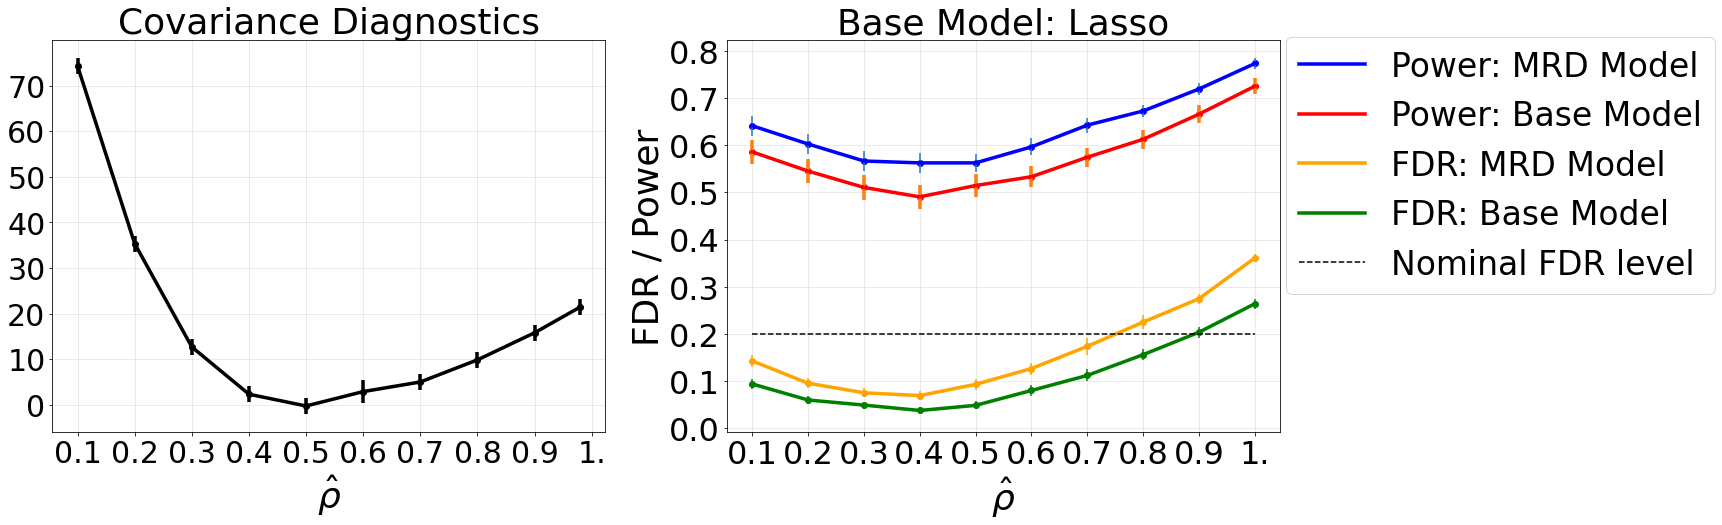

In [103]:
fig, (ax2, ax1) = plt.subplots(1,2,sharey=False,figsize=(22,0.9*8),gridspec_kw = {'wspace':0.22})
l1=[];l2=[];l3=[]

l1+=ax1.plot(signal_strength[1:], pow_T[1:], color='blue', label='Power: MRD Lasso',linewidth=lw)
ax1.scatter(signal_strength[1:], pow_T[1:], color='blue')
ax1.errorbar(signal_strength[1:],pow_T[1:],yerr=sem_T[1:], linestyle="None")


l1+=ax1.plot(signal_strength[1:], pow_0[1:], color='red', label='Power: Lasso',linewidth=lw)
ax1.scatter(signal_strength[1:], pow_0[1:], color='red')
ax1.errorbar(signal_strength[1:],pow_0[1:],yerr=sem_0[1:], linestyle="None",linewidth=lw)

    

l2+=ax2.plot(rhos[1:], means[1:], color='black', label='Goodness of Fit',linewidth=lw)
ax2.scatter(rhos[1:], means[1:], color='black')
ax2.errorbar(rhos[1:],means[1:],yerr=sems[1:], color='black', linestyle="None",linewidth=lw)



ax1.set_xlabel("Signal amplitude",fontsize=fz)
ax1.set_xlabel(r"$\hat{\rho}$",fontsize=fz)
ax1.set_ylabel("FDR / Power",fontsize=fz);
ax1.grid(alpha=0.3)





l1+=ax1.plot(signal_strength[1:], fdr_T[1:], color='orange', label='FDR: MRD Lasso',linewidth=lw)
ax1.scatter(signal_strength[1:], fdr_T[1:], color='orange')
ax1.errorbar(signal_strength[1:],fdr_T[1:],yerr=semf_T[1:],color='orange', linestyle="None")


l1+=ax1.plot(signal_strength[1:], fdr_0[1:], color='green', label='FDR: Lasso',linewidth=lw)
ax1.scatter(signal_strength[1:], fdr_0[1:], color='green')
ax1.errorbar(signal_strength[1:],fdr_0[1:],yerr=semf_0[1:],color='green', linestyle="None")

l1+=ax1.plot(signal_strength[1:], th * np.ones(len(signal_strength[1:])), linestyle='dashed', color='black') 
# leg1=ax1.legend(l1,['Power: MRD','Power: Base Model','FDR: MRD','FDR: Base Model','Nominal FDR level'],fontsize=fz-3);
leg2=ax1.legend(l1,['Power: MRD Model','Power: Base Model','FDR: MRD Model','FDR: Base Model','Nominal FDR level'],
                fontsize=fz-3,loc=(1.01,.8*.44));


ax1.set_title("Base Model: Lasso",fontsize=fz)
ax2.set_title("Covariance Diagnostics",fontsize=fz)
signal_strength[-1]=1
labels=[str(c) for c in signal_strength[1:]]
labels[-1]='1.'
ax2.set_xticks(ticks=signal_strength[1:])
ax2.set_xticklabels(labels)
ax2.set_xlabel(r"$\hat{\rho}$",fontsize=fz)
# ax2.set_ylabel("Goodness of Fit",fontsize=fz);
ax1.set_xticks(ticks=signal_strength[1:])
ax1.set_xticklabels(labels)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz-6)

for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz-6)

ax2.grid(alpha=0.3)

# for ax in fig.get_axes():
#     ax.label_outer()
fig.savefig('C:\\Users\\admin2.EEM-642\\Desktop\\Research\\results\\figs\\robustness_gof.png', format='png', dpi=300,bbox_inches = 'tight');

In [6]:
from scipy.stats import sem
import pandas as pd
from os import listdir
from os.path import isfile, join
import ast
load = True
if load:
    source = 'C:\\Users\\admin2.EEM-642\\Desktop\\Research\\MRD\\MRD_from_server\\results\\results_nonlinear_student_t_gmm_05gof_280122'#'''TODO: fill in the directory path'''
#     source = 'C:\\Users\\admin2.EEM-642\\Desktop\\Research\\HRT_plus\\results\\non_linear\\results_non_linear_n1000_random_sign_050921'#'''TODO: fill in the directory path'''
    list_files = [join(source, f) for f in listdir(source) if isfile(join(source, f))]
    gof_gmm = []
    cnt = 0
    for file in list_files:
        cnt+=1
        if not 'csv' in file:
            continue
#         print(file)
        df = pd.read_csv(file)
#         cc= df['c'][0]
#         c= df['est_rho'][0]
# #         if c!=0.16:
# #             continue
#         if c not in gof.keys():
#             rhos.append(c)
#             gof[c]=[]
#         print(df['gof'][0].replace('nan','0'))
        gof_l = np.array(ast.literal_eval(df['gof'][0].replace('nan','0')))
#         print(gof_l)
        gof_gmm.append(np.sum(gof_l))
np.mean(gof_gmm)


-0.007996258320897027

In [7]:
from scipy.stats import sem
import pandas as pd
from os import listdir
from os.path import isfile, join
import ast
load = True
if load:
    source = 'C:\\Users\\admin2.EEM-642\\Desktop\\Research\\MRD\\MRD_from_server\\results\\results_nonlinear_student_t_gs_05gof_280122'#'''TODO: fill in the directory path'''
#     source = 'C:\\Users\\admin2.EEM-642\\Desktop\\Research\\HRT_plus\\results\\non_linear\\results_non_linear_n1000_random_sign_050921'#'''TODO: fill in the directory path'''
    list_files = [join(source, f) for f in listdir(source) if isfile(join(source, f))]
    gof_gs = []
    cnt = 0
    for file in list_files:
        cnt+=1
        if not 'csv' in file:
            continue
#         print(file)
        df = pd.read_csv(file)
#         cc= df['c'][0]
#         c= df['est_rho'][0]
# #         if c!=0.16:
# #             continue
#         if c not in gof.keys():
#             rhos.append(c)
#             gof[c]=[]
#         print(df['gof'][0].replace('nan','0'))
        gof_l = np.array(ast.literal_eval(df['gof'][0].replace('nan','0')))
#         print(gof_l)
        gof_gs.append(np.sum(gof_l))
np.mean(gof_gs)


-0.006114650571473386

In [8]:
print(np.mean(gof_gs))
print(np.std(gof_gs))
print(np.mean(gof_gmm))
print(np.std(gof_gmm))

-0.006114650571473386
0.02591462188365407
-0.007996258320897027
0.025087099012111765


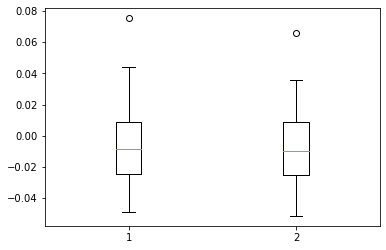

In [9]:
# import pandas as pd
# n = min(len(gof_gs),len(gof_gs))
# pd.DataFrame(np.stack((gof_gs[:n],gof_gmm[:n])).T).boxplot()

data = [gof_gs, gof_gmm]
fig7, ax7 = plt.subplots()
ax7.set_title('')
ax7.boxplot(data);

In [82]:
p_T = []
p_0 = []
f_T = []
f_0 = []
sp_T = []
sp_0 = []
sf_T = []
sf_0 = []

In [83]:
p_T.append(pow_T[0])
f_T.append(fdr_T[0])
p_0.append(pow_0[0])
f_0.append(fdr_0[0])
sp_T.append(sem_T[0])
sf_T.append(semf_T[0])
sp_0.append(sem_0[0])
sf_0.append(semf_0[0])


ValueError: x and y must have same first dimension, but have shapes (6,) and (1,)

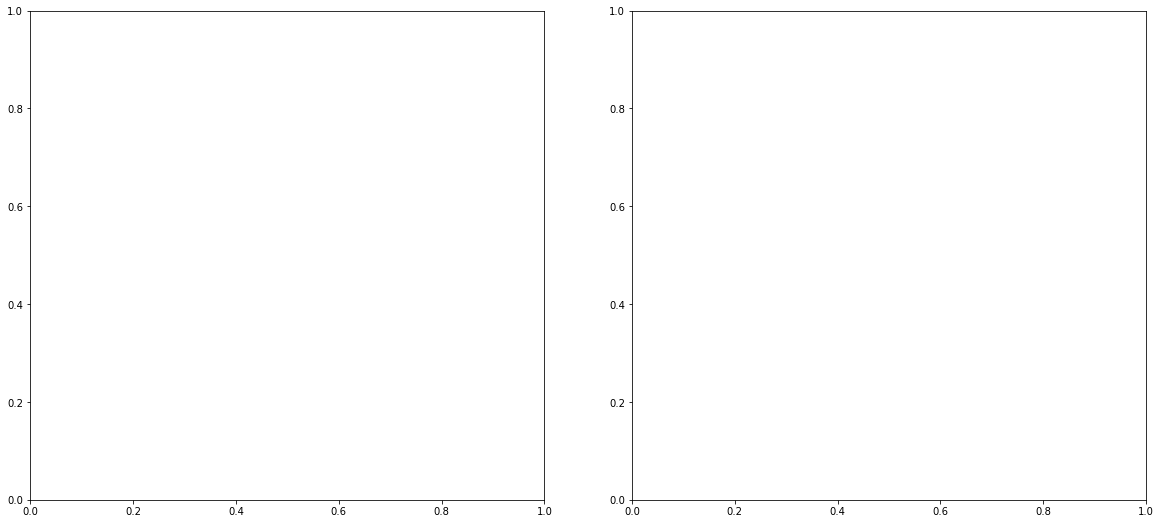

In [84]:
fz =31
signal_strength = [1000,1500,2000,2500,3000,4000]
fig, (ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(20,9),gridspec_kw = {'wspace':0.17})
l1=[];l2=[];l3=[]

l1+=ax1.plot(signal_strength, p_T, color='blue', label='Power: MRD Lasso',linewidth=lw)
ax1.scatter(signal_strength, p_T, color='blue')
ax1.errorbar(signal_strength,p_T,yerr=sp_T, linestyle="None")


l1+=ax1.plot(signal_strength, p_0, color='red', label='Power: Lasso',linewidth=lw)
ax1.scatter(signal_strength, p_0, color='red')
ax1.errorbar(signal_strength,p_0,yerr=sp_0, linestyle="None",linewidth=lw)


ax1.set_xlabel("Sample size",fontsize=fz)
ax1.set_ylabel("Power",fontsize=fz);
ax1.grid(alpha=0.3)


l1+=ax2.plot(signal_strength, f_T, color='orange', label='FDR: MRD Lasso',linewidth=lw)
ax2.scatter(signal_strength, f_T, color='orange')
ax2.errorbar(signal_strength,f_T,yerr=sf_T,color='orange', linestyle="None")

l1+=ax2.plot(signal_strength, f_0, color='green', label='FDR: Lasso',linewidth=lw)
ax2.scatter(signal_strength, f_0, color='green')
ax2.errorbar(signal_strength,f_0,yerr=sf_0,color='green', linestyle="None")



l1+=ax2.plot(signal_strength, th * np.ones(len(signal_strength)), linestyle='dashed', color='black') 
# leg1=ax1.legend(l1,['Power: MRD','Power: Base Model','FDR: MRD','FDR: Base Model','Nominal FDR level'],fontsize=fz-3);
leg3=ax2.legend(l1,['Power: MRD Lasso','Power: Lasso','FDR: MRD Lasso','FDR: Lasso','Nominal FDR level'],
                fontsize=fz-4)#,loc='upper left');#,loc=(1.01,.8*.44)


# ax1.set_title("Base Model: Lasso",fontsize=fz)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
ax2.set_ylim(0,0.5)
ax2.grid(alpha=0.3)
ax2.set_xlabel("Sample size",fontsize=fz)
ax2.set_ylabel("FDR",fontsize=fz);

In [72]:
len(powers_T[0.1])

50

In [247]:
for ii,c in enumerate(signal_strength):
    print(c,end = ' & ')
    print(f'{pow_T[ii]:.3f} & {fdr_T[ii]:.3f}',end = ' & ')
    print(f'{pow_0[ii]:.3f} & {fdr_0[ii]:.3f}',end = ' & ')
    print(f'{pow_ET[ii]:.3f} & {fdr_ET[ii]:.3f}',end = ' & ')
    print(f'{pow_E[ii]:.3f} & {fdr_E[ii]:.3f}',end = ' \\\\\n')

1.5 & 0.125 & 0.109 & 0.106 & 0.099 & nan & nan & nan & nan \\


C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-packages\numpy\core\fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


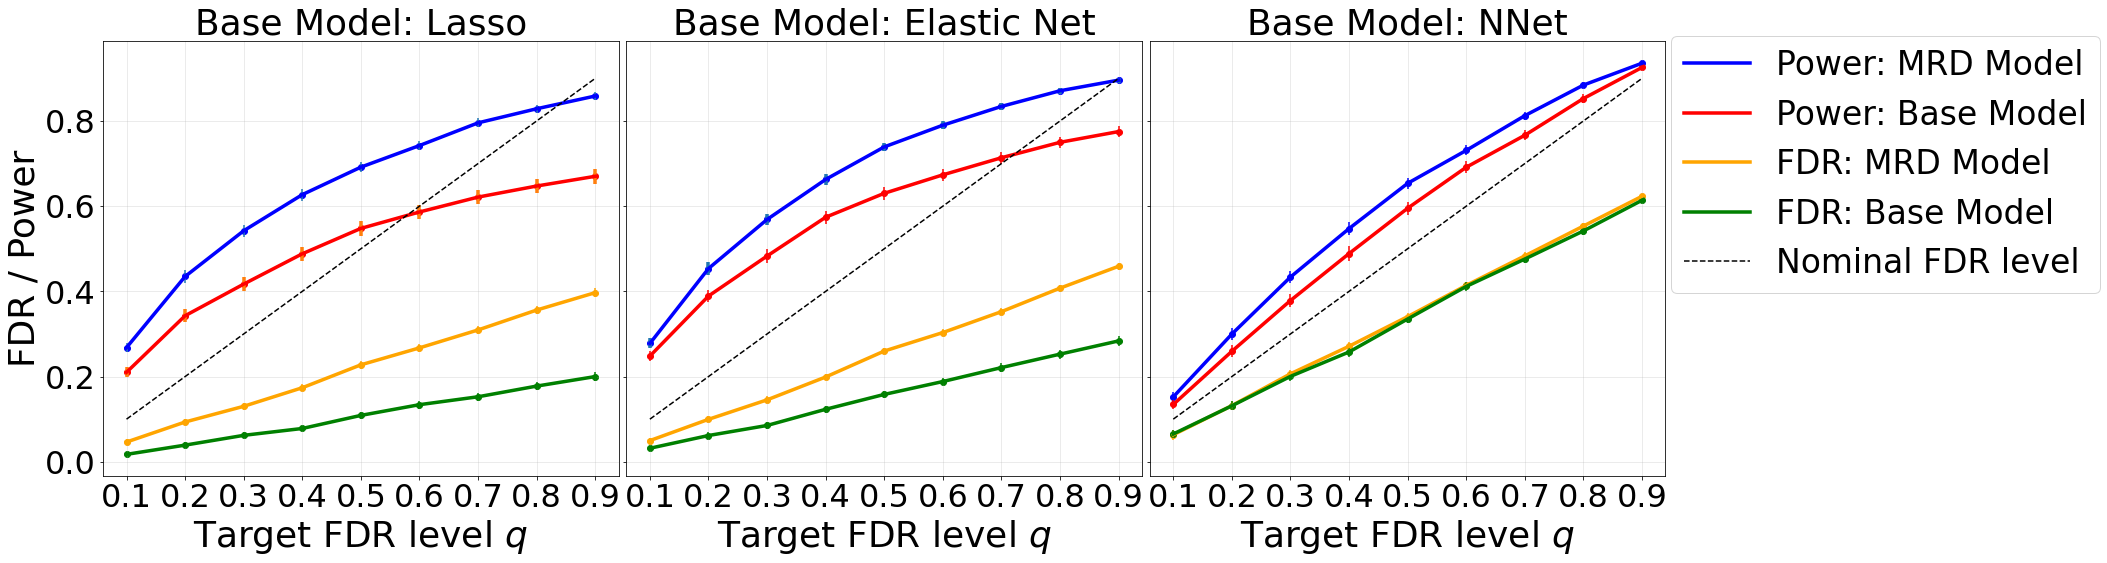

In [ ]:
###################### Power for a varying target FDR level and a constant signal strength #################
from scipy.stats import sem
import pandas as pd
from os import listdir
from os.path import isfile, join
import ast
lw=3.5
th=0.2
ths = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
fz=36
load = True
is_NN = True '''TODO: fill in whether you produced NN p-vals or not'''
signal_strength_to_eval = 0.14
if load:
    signal_strength=[]
    source = '''TODO: fill in the directory path'''
    list_files = [join(source, f) for f in listdir(source) if isfile(join(source, f))]
    powers_0 = {};powers_T = {};powers_E = {};powers_ET = {};powers_NN = {};powers_NN_T = {}; 
    fdrs_0 = {};fdrs_T = {};fdrs_E = {};fdrs_ET = {};fdrs_NN = {};fdrs_NN_T = {}; 
    for file in list_files:
        if not 'csv' in file:
            continue
        df = pd.read_csv(file)
        c= df['c'][0]
        if c != signal_strength_to_eval:
            continue
        for th in ths:
            c=th
            if th not in powers_0.keys():
                signal_strength.append(c)
                powers_0[c]=[]; fdrs_0[c]=[]
                powers_T[c]=[]; fdrs_T[c]=[]
                powers_ET[c]=[]; fdrs_ET[c]=[]
                powers_E[c]=[]; fdrs_E[c]=[]
                powers_NN[c]=[]; fdrs_NN[c]=[]
                powers_NN_T[c]=[]; fdrs_NN_T[c]=[]
            ones=df['ones'][0].replace('\n',',').replace('.',',')
            ones=np.array(ast.literal_eval(ones))
            if "NN" in file:
                if not is_NN:
                  continue

                p_vals_NN = ast.literal_eval(df['p_vals_NN'][0])
                disc,_,_,_=multipletests(np.array(p_vals_NN),alpha=th,method='fdr_bh')
                powers_NN[c].append(calc_power(disc,ones))
                fdrs_NN[c].append(calc_FDR(disc,ones))

                p_vals_NN_T = ast.literal_eval(df['p_vals_NN_T'][0])
                disc,_,_,_=multipletests(np.array(p_vals_NN_T),alpha=th,method='fdr_bh')
                powers_NN_T[c].append(calc_power(disc,ones))
                fdrs_NN_T[c].append(calc_FDR(disc,ones))

            else:
                p_vals_T = ast.literal_eval(df['p_vals_T'][0])
                p_vals_0 = ast.literal_eval(df['p_vals_0'][0])
                p_vals_ET = ast.literal_eval(df['p_vals_ET'][0])
                p_vals_E = ast.literal_eval(df['p_vals_E'][0])

                disc,_,_,_=multipletests(np.array(p_vals_T),alpha=th,method='fdr_bh')
                powers_T[c].append(calc_power(disc,ones))
                fdrs_T[c].append(calc_FDR(disc,ones))

                disc,_,_,_=multipletests(np.array(p_vals_0),alpha=th,method='fdr_bh')
                powers_0[c].append(calc_power(disc,ones))
                fdrs_0[c].append(calc_FDR(disc,ones))

                disc,_,_,_=multipletests(np.array(p_vals_ET),alpha=th,method='fdr_bh')
                powers_ET[c].append(calc_power(disc,ones))
                fdrs_ET[c].append(calc_FDR(disc,ones))

                disc,_,_,_=multipletests(np.array(p_vals_E),alpha=th,method='fdr_bh')
                powers_E[c].append(calc_power(disc,ones))
                fdrs_E[c].append(calc_FDR(disc,ones))

        signal_strength=np.sort(signal_strength)
   
pow_T = []; sem_T=[]
pow_0 = []; sem_0=[]
pow_ET = []; sem_ET=[]
pow_E = []; sem_E=[]
pow_NN = []; sem_NN=[]
pow_NN_T = []; sem_NN_T=[]

fdr_T = []; semf_T=[]
fdr_0 = []; semf_0=[]
fdr_ET = []; semf_ET=[]
fdr_E = []; semf_E=[]
fdr_NN = []; semf_NN=[]
fdr_NN_T = []; semf_NN_T=[]




for c in signal_strength:
  pow_T.append(np.mean(powers_T[c]))
  fdr_T.append(np.mean(fdrs_T[c]))
  sem_T.append(sem(powers_T[c]))
  semf_T.append(sem(fdrs_T[c]))

  pow_ET.append(np.mean(powers_ET[c]))
  fdr_ET.append(np.mean(fdrs_ET[c]))
  sem_ET.append(sem(powers_ET[c]))
  semf_ET.append(sem(fdrs_ET[c]))

  pow_0.append(np.mean(powers_0[c]))
  fdr_0.append(np.mean(fdrs_0[c]))
  sem_0.append(sem(powers_0[c]))
  semf_0.append(sem(fdrs_0[c]))

  pow_E.append(np.mean(powers_E[c]))
  fdr_E.append(np.mean(fdrs_E[c]))
  sem_E.append(sem(powers_E[c]))
  semf_E.append(sem(fdrs_E[c]))

  pow_NN.append(np.mean(powers_NN[c]))
  fdr_NN.append(np.mean(fdrs_NN[c]))
  sem_NN.append(sem(powers_NN[c]))
  semf_NN.append(sem(fdrs_NN[c]))

  pow_NN_T.append(np.mean(powers_NN_T[c]))
  fdr_NN_T.append(np.mean(fdrs_NN_T[c]))
  sem_NN_T.append(sem(powers_NN_T[c]))
  semf_NN_T.append(sem(fdrs_NN_T[c]))


fig, (ax1, ax2,ax3) = plt.subplots(1,3,sharey=True,figsize=(28,8),gridspec_kw = {'wspace':0.015})

l1=[];l2=[];l3=[]

l1+=ax1.plot(signal_strength, pow_T, color='blue', label='Power: MRD Lasso',linewidth=lw)
ax1.scatter(signal_strength, pow_T, color='blue')
ax1.errorbar(signal_strength,pow_T,yerr=sem_T, linestyle="None")


l1+=ax1.plot(signal_strength, pow_0, color='red', label='Power: Lasso',linewidth=lw)
ax1.scatter(signal_strength, pow_0, color='red')
ax1.errorbar(signal_strength,pow_0,yerr=sem_0, linestyle="None",linewidth=lw)

    
l3+=ax3.plot(signal_strength, pow_NN_T, color='blue', label='Power: MRD NN',linewidth=lw)
ax3.scatter(signal_strength, pow_NN_T, color='blue')
ax3.errorbar(signal_strength,pow_NN_T,yerr=sem_NN_T,color='blue', linestyle="None")

    
l3+=ax3.plot(signal_strength, pow_NN, color='red', label='Power: NN',linewidth=lw)
ax3.scatter(signal_strength, pow_NN, color='red')
ax3.errorbar(signal_strength,pow_NN,yerr=sem_NN,  color='red',linestyle="None")
    

   
l2+=ax2.plot(signal_strength, pow_ET, color='blue', label='Power: MRD ElasticNet',linewidth=lw)
ax2.scatter(signal_strength, pow_ET, color='blue')
ax2.errorbar(signal_strength,pow_ET,yerr=sem_ET, linestyle="None",linewidth=lw)


l2+=ax2.plot(signal_strength, pow_E, color='red', label='Power: ElasticNet',linewidth=lw)
ax2.scatter(signal_strength, pow_E, color='red')
ax2.errorbar(signal_strength,pow_E,yerr=sem_E,  color='red',linestyle="None")
                 

ax1.set_xlabel("Target FDR level $q$",fontsize=fz)
ax1.set_ylabel("FDR / Power",fontsize=fz);
ax1.grid(alpha=0.3)


l1+=ax1.plot(signal_strength, fdr_T, color='orange', label='FDR: MRD Lasso',linewidth=lw)
ax1.scatter(signal_strength, fdr_T, color='orange')
ax1.errorbar(signal_strength,fdr_T,yerr=semf_T,color='orange', linestyle="None")


l1+=ax1.plot(signal_strength, fdr_0, color='green', label='FDR: Lasso',linewidth=lw)
ax1.scatter(signal_strength, fdr_0, color='green')
ax1.errorbar(signal_strength,fdr_0,yerr=semf_0,color='green', linestyle="None")


l2+=ax2.plot(signal_strength, fdr_ET, color='orange', label='FDR: MRD Elastic Net',linewidth=lw)
ax2.plot(signal_strength, ths, linestyle='dashed', color='black')
ax2.scatter(signal_strength, fdr_ET, color='orange')
ax2.errorbar(signal_strength,fdr_ET,yerr=semf_ET,color='orange', linestyle="None")


l2+=ax2.plot(signal_strength, fdr_E, color='green', label='FDR: Elastic Net',linewidth=lw)
ax2.scatter(signal_strength, fdr_E, color='green')
ax2.errorbar(signal_strength,fdr_E,yerr=semf_E, color='green',linestyle="None")

    
l3+=ax3.plot(signal_strength, fdr_NN_T, color='orange',label="FDR: MRD NN",linewidth=lw)
ax3.scatter(signal_strength, fdr_NN_T, color='orange')
ax3.plot(signal_strength, ths, linestyle='dashed', color='black')
ax3.errorbar(signal_strength,fdr_NN_T,yerr=semf_NN_T, color='orange',linestyle="None")


l3+=ax3.plot(signal_strength, fdr_NN, color='green',label="FDR: NN",linewidth=lw)
ax3.scatter(signal_strength, fdr_NN, color='green')
ax3.errorbar(signal_strength,fdr_NN,yerr=semf_NN, color='green',linestyle="None")

l1+=ax1.plot(signal_strength, ths, linestyle='dashed', color='black') 
leg3=ax3.legend(l1,['Power: MRD Model','Power: Base Model','FDR: MRD Model','FDR: Base Model','Nominal FDR level'],
                fontsize=fz-3,loc=(1.01,.42));

ax1.set_title("Base Model: Lasso",fontsize=fz)
ax2.set_title("Base Model: Elastic Net",fontsize=fz)
ax3.set_title("Base Model: NNet",fontsize=fz)

ax2.set_xlabel("Target FDR level $q$",fontsize=fz)
ax2.set_ylabel("FDR / Power",fontsize=fz);
ax3.set_xlabel("Target FDR level $q$",fontsize=fz)
ax3.set_ylabel("FDR / Power",fontsize=fz);
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4)
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4)
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 

ax2.grid(alpha=0.3)

ax3.grid(alpha=0.3)

for ax in fig.get_axes():
    ax.label_outer()
    

# One hypothesis analysis

In [ ]:
from scipy.stats import sem
import pandas as pd
from os import listdir
from os.path import isfile, join
import ast
th=0.05
load = True
# load = False
is_NN = True '''TODO: fill in whether you produced NN p-vals or not'''
if load:
    signal_strength=[]
    source = '''TODO: fill in the directory path'''
    list_files = [join(source, f) for f in listdir(source) if isfile(join(source, f))]
    powers_0 = {};powers_T = {};powers_E = {};powers_ET = {};powers_NN = {};powers_NN_T = {};
    for file in list_files:
        if not 'csv' in file:
            continue
        df = pd.read_csv(file)
        c= df['c'][0]
        if c not in powers_0.keys():
            signal_strength.append(c)
            powers_0[c]=[]; fdrs_0[c]=[]
            powers_T[c]=[]; fdrs_T[c]=[]
            powers_ET[c]=[]; fdrs_ET[c]=[]
            powers_E[c]=[]; fdrs_E[c]=[]
            powers_NN[c]=[]; fdrs_NN[c]=[]
            powers_NN_T[c]=[]; fdrs_NN_T[c]=[]

        ones=df['ones'][0].replace('\n',',').replace('.',',')
        ones=np.array(ast.literal_eval(ones))
        id_to_check = ones.nonzero()[0][15]
        if "NN" in file:
            if not is_NN:
              continue
            p_vals_NN = ast.literal_eval(df['p_vals_NN'][0])
            p_vals_NN_T = ast.literal_eval(df['p_vals_NN_T'][0])
            
            powers_NN_T[c].append(1 if p_vals_NN_T[id_to_check]<=th else 0)
            powers_NN[c].append(1 if p_vals_NN[id_to_check]<=th else 0)


        else:
            p_vals_T = ast.literal_eval(df['p_vals_T'][0])
            p_vals_0 = ast.literal_eval(df['p_vals_0'][0])
            p_vals_ET = ast.literal_eval(df['p_vals_ET'][0])
            p_vals_E = ast.literal_eval(df['p_vals_E'][0])
       
            powers_T[c].append(1 if p_vals_T[id_to_check]<=th else 0)
            powers_0[c].append(1 if p_vals_0[id_to_check]<=th else 0)
            powers_ET[c].append(1 if p_vals_ET[id_to_check]<=th else 0)
            powers_E[c].append(1 if p_vals_E[id_to_check]<=th else 0)
    signal_strength=np.sort(signal_strength)
   
pow_T = []; sem_T=[]
pow_0 = []; sem_0=[]
pow_ET = []; sem_ET=[]
pow_E = []; sem_E=[]
pow_NN = []; sem_NN=[]
pow_NN_T = []; sem_NN_T=[]




for c in signal_strength:
  pow_T.append(np.mean(powers_T[c]))

  pow_ET.append(np.mean(powers_ET[c]))

  pow_0.append(np.mean(powers_0[c]))

  pow_E.append(np.mean(powers_E[c]))

  pow_NN.append(np.mean(powers_NN[c]))

  pow_NN_T.append(np.mean(powers_NN_T[c]))

fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True,figsize=(24,8),gridspec_kw = {'wspace':0.015})



l1=[];l2=[];l3=[]

l1+=ax1.plot(signal_strength, pow_T, color='blue', label='Power: MRD Lasso')
ax1.scatter(signal_strength, pow_T, color='blue')

l1+=ax1.plot(signal_strength, pow_0, color='red', label='Power: Lasso')
ax1.scatter(signal_strength, pow_0, color='red')

   
l2+=ax2.plot(signal_strength, pow_ET, color='blue', label='Power: MRD ElasticNet')
ax2.scatter(signal_strength, pow_ET, color='blue')


l2+=ax2.plot(signal_strength, pow_E, color='red', label='Power: ElasticNet')
ax2.scatter(signal_strength, pow_E, color='red')

                
l3+=ax3.plot(signal_strength, pow_NN_T, color='blue', label='Power: MRD NN')
ax3.scatter(signal_strength, pow_NN_T, color='blue')

l3+=ax3.plot(signal_strength, pow_NN, color='red', label='Power: NN')
ax3.scatter(signal_strength, pow_NN, color='red')

ax1.set_xlabel("Signal amplitude",fontsize=22)
ax1.set_ylabel("Power of a single feature, $\\alpha={}$".format(th),fontsize=22);
ax1.grid(alpha=0.3)

leg1=ax1.legend(l1,['MRD model','Base Model'],fontsize=22);    

ax2.set_xlabel("Signal amplitude",fontsize=22)
ax3.set_xlabel("Signal amplitude",fontsize=22)
ax2.set_ylabel("Power of a single feature, $\\alpha={}$".format(th),fontsize=22);

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

ax2.grid(alpha=0.3)
ax3.grid(alpha=0.3)
ax1.set_title("Base Model: Lasso",fontsize=22)
ax2.set_title("Base Model: ElasticNet",fontsize=22)
ax3.set_title("Base Model: NNet",fontsize=22)


for ax in fig.get_axes():
    ax.label_outer()


# Real data analysis

In [122]:
from os import listdir
from os.path import isfile, join
import ast
ths=[0.05,0.1,0.2,0.3,.4,.5,.6,.7,.8,.9]
load = True
p=150
if load:
    signal_strength=[]
    source = '''TODO: fill in the directory path'''
    list_files = [join(source, f) for f in listdir(source) if isfile(join(source, f))]
    list_files = np.sort(list_files)
    
    discs_ET = np.zeros(p);discs_E = np.zeros(p)
    mean_sum_T = []; mean_sum_0 = []; mean_sum_ET = []; mean_sum_E = []
    for i in range(len(ths)):
        mean_sum_T.append([]); mean_sum_0.append([]); mean_sum_ET.append([]); mean_sum_E.append([])
    for file in list_files:
        if not 'csv' in file:
            continue
        df = pd.read_csv(file)
        seed = int(df['seed'][0])
        
        
        p_vals_T = ast.literal_eval(df['p_vals_T'][0])
        p_vals_0 = ast.literal_eval(df['p_vals_0'][0])
        p_vals_ET = ast.literal_eval(df['p_vals_ET'][0])
        p_vals_E = ast.literal_eval(df['p_vals_E'][0])
        
        for i,th in enumerate(ths):
            sums_E = []; sums_ET=[]; sums_0 = []; sums_T=[]
            disc_ET,_,_,_=multipletests(np.array(p_vals_ET),alpha=th,method='fdr_bh')
            disc_E,_,_,_=multipletests(np.array(p_vals_E),alpha=th,method='fdr_bh')
            disc_T,_,_,_=multipletests(np.array(p_vals_T),alpha=th,method='fdr_bh')
            disc_0,_,_,_=multipletests(np.array(p_vals_0),alpha=th,method='fdr_bh')
            mean_sum_T[i].append(disc_T.sum());
            mean_sum_0[i].append(disc_0.sum());
            mean_sum_ET[i].append(disc_ET.sum());
            mean_sum_E[i].append(disc_E.sum());


T_to_plot=[]
l_to_plot=[]
ET_to_plot=[]
E_to_plot=[]
fz=30
lw=3
sem_0 = []; sem_T = []; sem_ET = []; sem_E = [];
for i in range(len(ths)):
    T_to_plot.append( np.mean(mean_sum_T[i]))
    l_to_plot.append( np.mean(mean_sum_0[i]))
    ET_to_plot.append( np.mean(mean_sum_ET[i]))
    E_to_plot.append( np.mean(mean_sum_E[i]))
    
    sem_T.append( sem(mean_sum_T[i]))
    sem_0.append( sem(mean_sum_0[i]))
    sem_ET.append( sem(mean_sum_ET[i]))
    sem_E.append( sem(mean_sum_E[i]))
    
to_show=4
fig,ax=plt.subplots(1, 1, figsize = (15,10))
ax.errorbar(ths[:to_show],T_to_plot[:to_show],yerr=sem_T[:to_show],color='blue')
ax.errorbar(ths[:to_show],ET_to_plot[:to_show],yerr=sem_ET[:to_show],color='green')
ax.errorbar(ths[:to_show],E_to_plot[:to_show],yerr=sem_E[:to_show],color='orange');
ax.errorbar(ths[:to_show],l_to_plot[:to_show],yerr=sem_0[:to_show],color='red')

ax.plot(ths[:to_show],T_to_plot[:to_show],marker='.',label='MRD Lasso',color='blue',linewidth=lw)
ax.plot(ths[:to_show],ET_to_plot[:to_show],marker='.',label='MRD Elastic Net',color='green',linewidth=lw)
ax.plot(ths[:to_show],E_to_plot[:to_show],marker='.',label='Elastic Net',color='orange',linewidth=lw);
ax.plot(ths[:to_show],l_to_plot[:to_show],marker='.',label='Lasso',color='red',linewidth=lw)
ax.grid(alpha=0.3)
ax.set_xlabel("Target FDR level $q$",fontsize=fz+2)#,weight='bold')
ax.set_ylabel("Average number of discoveries",fontsize=fz+2)#,weight='bold')
ax.set_xticks(ths[1:to_show])
ax.legend(fontsize=fz+3);

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'TODO: fill in the directory path'

# Choosing $\lambda$

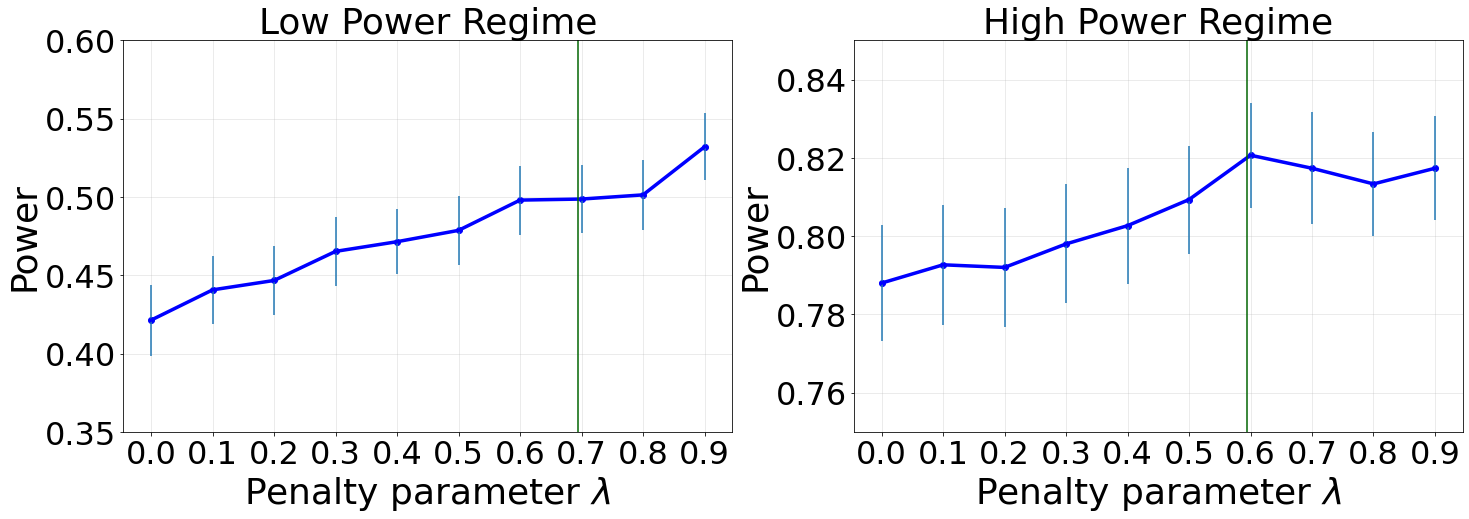

In [199]:
###################### Power to a constant target FDR level #################
from scipy.stats import sem
import pandas as pd
from os import listdir
from os.path import isfile, join
import ast
lw=3.5
th=0.2
fz=36
load = False
dcrt=False
cnt=0; cnt_t=0
thh=0.05
load = True
is_NN = False #'''TODO: fill in whether you produced NN p-vals or not'''
if load:
    powers_0 = {}; powers_T = {}; powers_E = {}; powers_ET = {}; powers_NN = {}; powers_NN_T = {}; powers_d = {};
    fdrs_0 = {};fdrs_T = {};fdrs_E = {};fdrs_ET = {};fdrs_NN = {};fdrs_NN_T = {}; fdrs_d = {};
    signal_strength=[0]
for lmbda in range(1,10):
#     if lmbda == 5:
#         continue
    if load:
        source = 'C:\\Users\\admin2.EEM-642\\Desktop\\Research\\results\\from_server\\results_non_linear\\results_non_linear_lmbda0{}_random_sign_120921'.format(lmbda)#'''TODO: fill in the directory path'''
        list_files = [join(source, f) for f in listdir(source) if isfile(join(source, f))]

        for file in list_files:
            if not 'csv' in file:
                continue
#             print(file)
            try:
                df = pd.read_csv(file)
            except:
                continue
            cc= df['c'][0]
            seed= int(df['seed'][0])
            if seed>50:
                continue
            c = lmbda
            if c not in powers_0.keys():
                signal_strength.append(c)
                powers_0[c]=[]; fdrs_0[c]=[]
                powers_T[c]=[]; fdrs_T[c]=[]
                powers_ET[c]=[]; fdrs_ET[c]=[]
                powers_E[c]=[]; fdrs_E[c]=[]
                powers_NN[c]=[]; fdrs_NN[c]=[]
                powers_NN_T[c]=[]; fdrs_NN_T[c]=[]
                powers_d[c]=[]; fdrs_d[c]=[]
            ones=df['ones'][0].replace('\n',',').replace('.',',').replace(',,',',')
            ones=np.array(ast.literal_eval(ones))
            if "NN" in file:
                pass
            else:
                p_vals_T = ast.literal_eval(df['p_vals_T'][0])
                p_vals_0 = ast.literal_eval(df['p_vals_0'][0])

                fdr_control = 0.99
                if cc == 0.14:
                    disc,_,_,_=multipletests(np.array(p_vals_T),alpha=th,method='fdr_bh')
                    if calc_FDR(disc,ones) < fdr_control:
                        powers_T[c].append(calc_power(disc,ones))
                        fdrs_T[c].append(calc_FDR(disc,ones))

                    disc,_,_,_=multipletests(np.array(p_vals_0),alpha=th,method='fdr_bh')
                    if calc_FDR(disc,ones) < fdr_control:
                        powers_0[c].append(calc_power(disc,ones))
                        fdrs_0[c].append(calc_FDR(disc,ones))

                if cc ==0.16:
                    disc,_,_,_=multipletests(np.array(p_vals_T),alpha=th,method='fdr_bh')
                    if calc_FDR(disc,ones) < fdr_control:
                        powers_ET[c].append(calc_power(disc,ones))
                        fdrs_ET[c].append(calc_FDR(disc,ones))

                    disc,_,_,_=multipletests(np.array(p_vals_0),alpha=th,method='fdr_bh')
                    if calc_FDR(disc,ones) < fdr_control:
                        powers_E[c].append(calc_power(disc,ones))
                        fdrs_E[c].append(calc_FDR(disc,ones))
powers_T[0] = powers_0[1]
powers_ET[0] = powers_E[1]
pow_T = []; sem_T=[]
pow_0 = []; sem_0=[]
pow_ET = []; sem_ET=[]
pow_E = []; sem_E=[]
pow_d = []; sem_d=[]
pow_NN = []; sem_NN=[]
pow_NN_T = []; sem_NN_T=[]
fdr_T = []; semf_T=[]
fdr_0 = []; semf_0=[]
fdr_ET = []; semf_ET=[]
fdr_E = []; semf_E=[]
fdr_NN = []; semf_NN=[]
fdr_NN_T = []; semf_NN_T=[]
fdr_d = []; semf_d=[]



for c in signal_strength:
  pow_T.append(np.mean(powers_T[c]))
#   fdr_T.append(np.mean(fdrs_T[c]))
  sem_T.append(sem(powers_T[c]))
#   semf_T.append(sem(fdrs_T[c]))

  pow_ET.append(np.mean(powers_ET[c]))
#   fdr_ET.append(np.mean(fdrs_ET[c]))
  sem_ET.append(sem(powers_ET[c]))
#   semf_ET.append(sem(fdrs_ET[c]))

fig, (ax1, ax2) = plt.subplots(1,2,sharey=False,figsize=(24,0.9*8),gridspec_kw = {'wspace':0.2})
l1=[];l2=[]
signal_strength = np.array(signal_strength)/10

l1+=ax1.plot(signal_strength, pow_T, color='blue', label='Power: MRD Lasso',linewidth=lw)
ax1.scatter(signal_strength, pow_T, color='blue')
ax1.errorbar(signal_strength,pow_T,yerr=sem_T, linestyle="None")

l2+=ax2.plot(signal_strength, pow_ET, color='blue', label='Power: MRD ElasticNet',linewidth=lw)
ax2.scatter(signal_strength, pow_ET, color='blue')
ax2.errorbar(signal_strength,pow_ET,yerr=sem_ET, linestyle="None")


ax1.set_xlabel("Penalty parameter $\lambda$",fontsize=fz)
ax1.set_ylabel("Power",fontsize=fz);
ax1.grid(alpha=0.3)



ax1.set_title("Low Power Regime",fontsize=fz)
ax1.set_xticks(signal_strength)
ax2.set_title("High Power Regime",fontsize=fz)
ax2.set_xticks(signal_strength)


ax2.set_xlabel("Penalty parameter $\lambda$",fontsize=fz)
ax2.set_ylabel("Power",fontsize=fz);

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4)

ax1.set_ylim(0.35,0.6)
ax2.set_ylim(0.75,0.85)
ax2.grid(alpha=0.3)
ax1.axvline(0.694,color='darkgreen')
ax2.axvline(0.594,color='darkgreen');
# remove inner plots' ticks
# for ax in fig.get_axes():
#     ax.label_outer()
    
fig.savefig('C:\\Users\\admin2.EEM-642\\Desktop\\Research\\results\\figs\\varying_lambda.png', format='png', dpi=300,bbox_inches = 'tight');

In [186]:
from scipy import sparse
import re
from sklearn.linear_model import Lasso
def set_seed(seed):
    try:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
    except:
        pass
    np.random.seed(seed)

def create_sparse_vector(rows=1000, density=0.2,seed=0):
    # np.random.seed(0)
    S = sparse.random(m=rows, n=1, density=density, format='coo', dtype=None, random_state=seed, data_rvs=None)
#     S = sparse.random(m=rows, n=1, density=density, format='coo', dtype=None,  data_rvs=None)
    sparse_vec = S.A
    beta = [sparse_vec != 0][0].astype(int)
    return beta

def create_normal_noise(mu, sigma, shape):
    return np.random.normal(mu, sigma, (shape[0], shape[1]))

def create_AR1_Sigma(p,rho=0.5):
  Sigma = np.eye(p)
  for i in range(p):
    for j in range(p):
      Sigma[i,j] = rho**(abs(i-j))
  mu = np.zeros((p,1)).ravel()
  return mu,Sigma


from scipy.stats import sem
import pandas as pd
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import StandardScaler
import ast
lw=3.5
th=0.2
fz=36
load = True
flag=False
cnt=0; cnt_t=0
thh=0.05
# load = False
is_NN = False #'''TODO: fill in whether you produced NN p-vals or not'''
if load:
    mses = []
#     signal_strength=[0]
for lmbda in range(1,10):
#     if lmbda == 5:
#         continue
    if load:
        mses = []
        source = 'C:\\Users\\admin2.EEM-642\\Desktop\\Research\\results\\from_server\\results_non_linear\\results_non_linear_lmbda0{}_random_sign_120921'.format(lmbda)#'''TODO: fill in the directory path'''
        list_files = [join(source, f) for f in listdir(source) if isfile(join(source, f))]

        for file in list_files:
            if not 'csv' in file:
                continue
    #         print(file)
            try:
                df = pd.read_csv(file)
            except:
                continue
            c= df['c'][0]
            if c<0.15:
                continue
            seed = df['seed'][0]
            set_seed(seed)
            n=800;p=100
            X_mu, X_Sigma = create_AR1_Sigma(p, rho=0.1)
            ones = create_sparse_vector(p, 0.3)
            rng = range(p)
            for i,one in enumerate(ones):
              #ones[i] = 1 if i <= int(0.3*p) else 0
              if np.random.rand() > 0.5:
                  ones[i]=-one
            beta = c * ones
            X = np.random.multivariate_normal(X_mu, X_Sigma, n)
            v = create_normal_noise(mu=0, sigma=1, shape=(n, 1))
            Y = 0.5*np.power(X @ beta,3) + v 

            X_train = X[0:int(0.5 * n)]
            Y_train = Y[0:int(0.5 * n)]
            X_test = X[int(0.5 * n) + 1:]
            Y_test = Y[int(0.5 * n) + 1:]

            scaler_X=StandardScaler().fit(X_train)
            scaler_Y=StandardScaler().fit(Y_train)
            X_train, Y_train =scaler_X.transform(X_train), scaler_Y.transform(Y_train)
            X_test, Y_test =scaler_X.transform(X_test), scaler_Y.transform(Y_test)
            if not flag:
                m = Lasso(fit_intercept=False).fit(X_train,Y_train.ravel())
                flag=True
            lasso = ast.literal_eval(re.sub(',' + '{2,}',',',df['lasso_T'][0].replace('\n',',').replace(',,',',').replace('[ ','[').replace(' ',',')))
            m.coef_ = np.array(lasso)
#             print(m.coef_.sum())
            mses.append(((m.predict(X_test)-Y_test.ravel())**2).mean())
    print(len(mses))
    print("mse: ",np.mean(mses))


100
mse:  0.7420480682725413
100
mse:  0.7414064840283481
100
mse:  0.7411757194099279
100
mse:  0.7416049202632028
98
mse:  0.7398389147406728
100
mse:  0.7462998329371666
100
mse:  0.7526990527945437
100
mse:  0.7657116633143766
100
mse:  0.7864439320721236


In [190]:
0.8*0.74247

0.593976

# $\lambda$ analysis

In [70]:
from scipy import sparse
import re
from sklearn.linear_model import Lasso
def set_seed(seed):
    try:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
    except:
        pass
    np.random.seed(seed)

def create_sparse_vector(rows=1000, density=0.2,seed=0):
    # np.random.seed(0)
    S = sparse.random(m=rows, n=1, density=density, format='coo', dtype=None, random_state=seed, data_rvs=None)
#     S = sparse.random(m=rows, n=1, density=density, format='coo', dtype=None,  data_rvs=None)
    sparse_vec = S.A
    beta = [sparse_vec != 0][0].astype(int)
    return beta

def create_normal_noise(mu, sigma, shape):
    return np.random.normal(mu, sigma, (shape[0], shape[1]))

def create_AR1_Sigma(p,rho=0.5):
  Sigma = np.eye(p)
  for i in range(p):
    for j in range(p):
      Sigma[i,j] = rho**(abs(i-j))
  mu = np.zeros((p,1)).ravel()
  return mu,Sigma

def create_conditional_gauss(X, j, mu=None, sigma=None):
    a = np.delete(X, j, 1)
    if mu is None:
        mu = np.mean(X, axis=0)
    mu_1 = np.array([mu[j]])
    mu_2 = np.delete(mu, j, 0)
    if sigma is None:
        sigma = np.cov(X.T)
    sigma_11 = sigma[j, j]
    sigma_12 = np.delete(sigma, j, 1)[j, :]
    sigma_21 = np.delete(sigma, j, 0)[:, j]
    sigma_22 = np.delete(np.delete(sigma, j, 0), j, 1)
    mu_bar_vec = []
    sigma12_22 = sigma_12 @ np.linalg.inv(sigma_22)
    sigma_bar = sigma_11 - sigma12_22 @ sigma_21
    for a_i in a:
        mu_bar = mu_1 + sigma12_22 @ (a_i - mu_2)
        mu_bar_vec.append(mu_bar)

    return mu_bar_vec, np.sqrt(sigma_bar)

def generate_conditional_data(X, X_mu, X_Sigma, ftrs_=None):
    n, p = X.shape
    ftrs = range(p) if ftrs_ is None else ftrs_
    if X_mu is None:
      X_mu = np.mean(X,axis=0)
    if X_Sigma is None:
      X_Sigma = np.cov(X.T)
    X_tilda = X.copy()
    for j in ftrs:#range(p):
        mu_tilda, sigma_tilda = create_conditional_gauss(X, j, X_mu, X_Sigma)
        Xj_tilda = create_normal_noise(mu=mu_tilda, sigma=sigma_tilda, shape=(n, 1))
        X_tilda[:, j] = Xj_tilda.ravel().copy()
    return X_tilda

def generate_fake_data(X, X_mu, X_Sigma, j):
    n, p = X.shape
    mu_tilda, sigma_tilda = create_conditional_gauss(X, j, X_mu, X_Sigma)
    Xj_tilda = create_normal_noise(mu=mu_tilda, sigma=sigma_tilda, shape=(n, 1))
    X_tilda = X.copy()
    X_tilda[:, j] = Xj_tilda.ravel()
    return X_tilda,mu_tilda, sigma_tilda

n=1000000;p=3
lmb = 0.9
X_mu, X_Sigma = create_AR1_Sigma(p, rho=0.)
X = np.random.multivariate_normal(X_mu, X_Sigma, n)
X_tilda = generate_conditional_data(X, X_mu, X_Sigma)
# X0_tilda,_,_ = generate_fake_data(X, X_mu, X_Sigma, 0)
v = create_normal_noise(mu=0, sigma=1, shape=(n, 1))
Y = X[:,0].ravel() + X[:,2].ravel() + v.ravel() 
b2_vec = np.linspace(-0.5, 0.5, num=10, endpoint=True)
b1_vec = np.linspace(0, 3, num=10, endpoint=True)
b3_vec = np.linspace(0, 3, num=10, endpoint=True)
best = np.inf
best_bs = None
for b1 in b1_vec:
    for b2 in b2_vec:
        for b3 in b3_vec:
            Y_hat = b1*X[:,0].ravel() + b2*X[:,1].ravel() + b3*X[:,2].ravel()
            Y1_hat_tilda = b1*X_tilda[:,0].ravel() + b2*X[:,1].ravel() + b3*X[:,2].ravel()
            Y2_hat_tilda = b2*X_tilda[:,1].ravel() + b1*X[:,0].ravel() + b3*X[:,2].ravel()
            Y3_hat_tilda = b3*X_tilda[:,2].ravel() + b2*X[:,1].ravel() + b1*X[:,0].ravel()
            t = ((Y_hat.ravel() - Y.ravel())**2).mean()
            t_tilda = ((Y_hat_tilda.ravel() - Y.ravel())**2).mean()
            loss = (1-lmb)*t + lmb*(t-t_tilda)
            if loss < best:
                best = loss
                best_bs = (b1,b2,b3)

print(best_bs)              



(3.0, -0.05555555555555558, 1.0)


In [64]:
b1 = 1; b2 =0
b1,b2 = best_bs
Y_hat = b1*X[:,0].ravel() + b2*X[:,1].ravel()# + b3*X[:,2].ravel()
Y_hat_tilda = b1*X0_tilda[:,0].ravel() + b2*X[:,1].ravel()# + b3*X[:,2].ravel()
t = ((Y_hat.ravel() - Y.ravel())**2).mean()
t_tilda = ((Y_hat_tilda.ravel() - Y.ravel())**2).mean()
loss = (1-lmb)*t + lmb*(t-t_tilda)
print(loss)
best


0.0056923823494159365


0.0056923823494159365

In [76]:
# X_mu, X_Sigma = create_AR1_Sigma(p, rho=0.)
# X = np.random.multivariate_normal(X_mu, X_Sigma, n)
# # X_tilda = generate_conditional_data(X, X_mu, X_Sigma)
# X0_tilda,_,_ = generate_fake_data(X, X_mu, X_Sigma, 0)
(X[:,0]*X0_tilda[:,0]).mean()

0.00024380793400119422

In [73]:
X_Sigma

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [74]:
np.cov(X[:,0],X0_tilda[:,0])

array([[ 9.98398661e-01, -7.31634841e-04],
       [-7.31634841e-04,  1.00096661e+00]])

In [201]:
txt = 'C:\\Users\\admin2.EEM-642\\Desktop\\Research\\table.txt'
f = open(txt)
lines = f.readlines()
lines[0].replace('\\\\\n','').replace(' ','').split('&')
for line in lines:
    l = line.replace('\\\\\n','').replace(' ','').replace('\\\\','').split('&')
#     print(l)
    print(l[0],end = '&')
    print(l[3],end = '&')
    print(l[1],end = '&')
    print('{:.1f}'.format(100*(float(l[1])/float(l[3])-1)),end = '&')
    print(l[7],end = '&')
    print(l[5],end = '&')
    print('{:.1f}'.format(100*(float(l[5])/float(l[7])-1)),end = '\\\\ \n')
#     print('{:.1f}'.format(100*(float(l[5])/float(l[7])-1)),end = '&')
#     print(l[11],end = '&')
#     print(l[9],end = '&')
#     print('{:.1f}'.format(100*(float(l[9])/float(l[11])-1)),end = '\\\\ \n')

0.08&0.081&0.143&76.5&0.113&0.153&35.4\\ 
0.1&0.233&0.324&39.1&0.287&0.375&30.7\\ 
0.12&0.486&0.550&13.2&0.524&0.577&10.1\\ 
0.14&0.702&0.731&4.1&0.715&0.753&5.3\\ 
0.16&0.838&0.854&1.9&0.842&0.856&1.7\\ 
0.18&0.914&0.919&0.5&0.915&0.917&0.2\\ 


# Interactions

C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-packages\numpy\core\fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\admin2.EEM-642\anaconda3\envs\Shalev\lib\site-pack

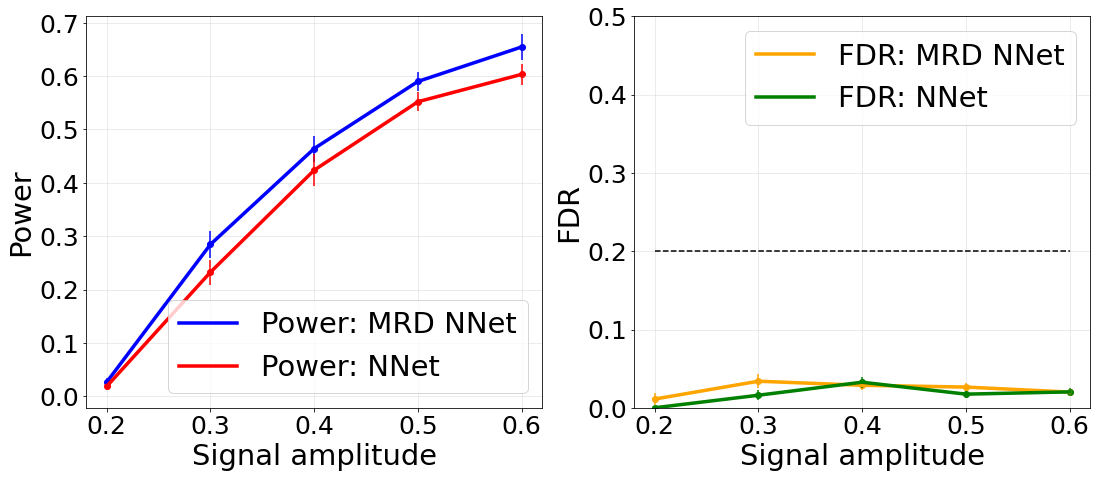

In [24]:
###################### Power to a constant target FDR level #################
from scipy.stats import sem
import pandas as pd
from os import listdir
from os.path import isfile, join
import ast
lw=3.5
th=0.2
fz=29
load = True
dcrt=False
cnt=0; cnt_t=0
thh=0.05
# load = False
is_NN = True #'''TODO: fill in whether you produced NN p-vals or not'''
if load:
    signal_strength=[]
    source = 'C:\\Users\\admin2.EEM-642\\Desktop\\Research\\results\\from_server\\results_non_linear\\results_non_linear_inter_NN_300921_best_so_far'#'''TODO: fill in the directory path'''
#     source = 'C:\\Users\\admin2.EEM-642\\Desktop\\Research\\HRT_plus\\results\\non_linear\\results_non_linear_inetractions_rf_090821'#'''TODO: fill in the directory path'''
    list_files = [join(source, f) for f in listdir(source) if isfile(join(source, f))]
    powers_0 = {}; powers_T = {}; powers_E = {}; powers_ET = {}; powers_NN = {}; powers_NN_T = {}; powers_d = {};
    fdrs_0 = {};fdrs_T = {};fdrs_E = {};fdrs_ET = {};fdrs_NN = {};fdrs_NN_T = {}; fdrs_d = {};
    for file in list_files:
        if not 'csv' in file:
            continue
#         print(file)
        df = pd.read_csv(file)
        c= df['c'][0]
#         if c>0.18:
#             continue
        if c not in powers_0.keys():
            signal_strength.append(c)
            powers_0[c]=[]; fdrs_0[c]=[]
            powers_T[c]=[]; fdrs_T[c]=[]
            powers_ET[c]=[]; fdrs_ET[c]=[]
            powers_E[c]=[]; fdrs_E[c]=[]
            powers_NN[c]=[]; fdrs_NN[c]=[]
            powers_NN_T[c]=[]; fdrs_NN_T[c]=[]
            powers_d[c]=[]; fdrs_d[c]=[]
        ones=df['ones'][0].replace('\n',',').replace('.',',').replace(',,',',')
        ones=np.array(ast.literal_eval(ones))
        if "NN" in file:
            if not is_NN:
              continue
            p_vals_NN = ast.literal_eval(df['p_vals_NN'][0])
            if p_vals_NN[1]<thh:
                cnt+=1
            disc,_,_,_=multipletests(np.array(p_vals_NN),alpha=th,method='fdr_by')
            powers_NN[c].append(calc_power(disc,ones))
            fdrs_NN[c].append(calc_FDR(disc,ones))

            p_vals_NN_T = ast.literal_eval(df['p_vals_NN_T'][0])
            if p_vals_NN_T[1]<thh:
                cnt_t+=1
            disc,_,_,_=multipletests(np.array(p_vals_NN_T),alpha=th,method='fdr_by')
            powers_NN_T[c].append(calc_power(disc,ones))
            fdrs_NN_T[c].append(calc_FDR(disc,ones))
        else:
            p_vals_T = ast.literal_eval(df['p_vals_T'][0])
            p_vals_0 = ast.literal_eval(df['p_vals_0'][0])
            p_vals_ET = ast.literal_eval(df['p_vals_ET'][0])
            p_vals_E = ast.literal_eval(df['p_vals_E'][0])
#             if not dcrt:
#                 p_vals_d = ast.literal_eval(df['p_vals_d'][0])                
       
            fdr_control = 0.99
            disc,_,_,_=multipletests(np.array(p_vals_T),alpha=th,method='fdr_bh')
            if calc_FDR(disc,ones) < fdr_control:
                powers_T[c].append(calc_power(disc,ones))
                fdrs_T[c].append(calc_FDR(disc,ones))

            disc,_,_,_=multipletests(np.array(p_vals_0),alpha=th,method='fdr_bh')
            if calc_FDR(disc,ones) < fdr_control:
                powers_0[c].append(calc_power(disc,ones))
                fdrs_0[c].append(calc_FDR(disc,ones))
                
#             if not dcrt:
#                 disc,_,_,_=multipletests(np.array(p_vals_d),alpha=th,method='fdr_bh')
#                 if df['seed'][0] == 17:
#                     print('dcrt',calc_power(disc,ones))
#                 if calc_FDR(disc,ones) < fdr_control:
#                     powers_d[c].append(calc_power(disc,ones))
#                     fdrs_d[c].append(calc_FDR(disc,ones))

#             disc,_,_,_=multipletests(np.array(p_vals_ET),alpha=th,method='fdr_bh')
#             if calc_FDR(disc,ones) < fdr_control:
#                 powers_ET[c].append(calc_power(disc,ones))
#                 fdrs_ET[c].append(calc_FDR(disc,ones))

#             disc,_,_,_=multipletests(np.array(p_vals_E),alpha=th,method='fdr_bh')
#             if calc_FDR(disc,ones) < fdr_control:
#                 powers_E[c].append(calc_power(disc,ones))
#                 fdrs_E[c].append(calc_FDR(disc,ones))

    if dcrt:
        source = "C:\\Users\\admin2.EEM-642\\Desktop\\Research\\MRD\\MRD_from_server\\results\\dcrt\\results_non_inear_elnet_and_dcrt_CV1_n600_rho06_random_sign_group_240821\\"
        list_files = [join(source, f) for f in listdir(source) if isfile(join(source, f))]
        for file in list_files:
            if not 'csv' in file:
                continue
            df = pd.read_csv(file)
            p_vals_d = list(df['x'])
            disc,_,_,_=multipletests(np.array(p_vals_d),alpha=th,method='fdr_bh')
            if calc_FDR(disc,ones) < fdr_control:
                powers_d[c].append(calc_power(disc,ones))
                fdrs_d[c].append(calc_FDR(disc,ones))
    signal_strength=np.sort(signal_strength)

pow_T = []; sem_T=[]
pow_0 = []; sem_0=[]
pow_ET = []; sem_ET=[]
pow_E = []; sem_E=[]
pow_d = []; sem_d=[]
pow_NN = []; sem_NN=[]
pow_NN_T = []; sem_NN_T=[]
fdr_T = []; semf_T=[]
fdr_0 = []; semf_0=[]
fdr_ET = []; semf_ET=[]
fdr_E = []; semf_E=[]
fdr_NN = []; semf_NN=[]
fdr_NN_T = []; semf_NN_T=[]
fdr_d = []; semf_d=[]



for c in signal_strength:
  pow_T.append(np.mean(powers_T[c]))
  fdr_T.append(np.mean(fdrs_T[c]))
  sem_T.append(sem(powers_T[c]))
  semf_T.append(sem(fdrs_T[c]))

  pow_ET.append(np.mean(powers_ET[c]))
  fdr_ET.append(np.mean(fdrs_ET[c]))
  sem_ET.append(sem(powers_ET[c]))
  semf_ET.append(sem(fdrs_ET[c]))

  pow_0.append(np.mean(powers_0[c]))
  fdr_0.append(np.mean(fdrs_0[c]))
  sem_0.append(sem(powers_0[c]))
  semf_0.append(sem(fdrs_0[c]))

  pow_E.append(np.mean(powers_E[c]))
  fdr_E.append(np.mean(fdrs_E[c]))
  sem_E.append(sem(powers_E[c]))
  semf_E.append(sem(fdrs_E[c]))

  pow_NN.append(np.mean(powers_NN[c]))
  fdr_NN.append(np.mean(fdrs_NN[c]))
  sem_NN.append(sem(powers_NN[c]))
  semf_NN.append(sem(fdrs_NN[c]))

  pow_NN_T.append(np.mean(powers_NN_T[c]))
  fdr_NN_T.append(np.mean(fdrs_NN_T[c]))
  sem_NN_T.append(sem(powers_NN_T[c]))
  semf_NN_T.append(sem(fdrs_NN_T[c]))
    
  pow_d.append(np.mean(powers_d[c]))
  fdr_d.append(np.mean(fdrs_d[c]))
  sem_d.append(sem(powers_d[c]))
  semf_d.append(sem(fdrs_d[c]))


fig, (ax3, ax2) = plt.subplots(1,2,sharey=False,figsize=(18,0.9*8))#,gridspec_kw = {'wspace':0.015})
l1=[];l2=[];l3=[]

l1+=ax1.plot(signal_strength, pow_T, color='blue', label='Power: MRD Lasso',linewidth=lw)
ax1.scatter(signal_strength, pow_T, color='blue')
ax1.errorbar(signal_strength,pow_T,yerr=sem_T, linestyle="None")


l1+=ax1.plot(signal_strength, pow_0, color='red', label='Power: Lasso',linewidth=lw)
ax1.scatter(signal_strength, pow_0, color='red')
ax1.errorbar(signal_strength,pow_0,yerr=sem_0, linestyle="None",linewidth=lw)

l1+=ax1.plot(signal_strength, pow_d, color='green', label='Power: dcrt',linewidth=lw)
ax1.scatter(signal_strength, pow_d, color='green')
ax1.errorbar(signal_strength,pow_d,yerr=sem_d, linestyle="None",linewidth=lw)

    
l3+=ax3.plot(signal_strength, pow_NN_T, color='blue', label='Power: MRD NNet',linewidth=lw)
ax3.scatter(signal_strength, pow_NN_T, color='blue')
ax3.errorbar(signal_strength,pow_NN_T,yerr=sem_NN_T,color='blue', linestyle="None")

    
l3+=ax3.plot(signal_strength, pow_NN, color='red', label='Power: NNet',linewidth=lw)
ax3.scatter(signal_strength, pow_NN, color='red')
ax3.errorbar(signal_strength,pow_NN,yerr=sem_NN,  color='red',linestyle="None")

    



ax1.set_xlabel("Signal amplitude",fontsize=fz)
ax1.set_ylabel("FDR / Power",fontsize=fz);
ax1.grid(alpha=0.3)


l1+=ax1.plot(signal_strength, fdr_T, color='orange', label='FDR: MRD Lasso',linewidth=lw)
ax1.scatter(signal_strength, fdr_T, color='orange')
ax1.errorbar(signal_strength,fdr_T,yerr=semf_T,color='orange', linestyle="None")

l1+=ax1.plot(signal_strength, fdr_d, color='black', label='FDR: dcrt',linewidth=lw)
ax1.scatter(signal_strength, fdr_d, color='black')
ax1.errorbar(signal_strength,fdr_d,yerr=semf_d,color='black', linestyle="None")

# if plot_sem:
#     ax2.fill_between(signal_strength, np.array(fdr_T) - np.array(semf_T),
#                       np.array(fdr_T) + np.array(semf_T), alpha=0.25, color='blue')

l1+=ax1.plot(signal_strength, fdr_0, color='green', label='FDR: Lasso',linewidth=lw)
ax1.scatter(signal_strength, fdr_0, color='green')
ax1.errorbar(signal_strength,fdr_0,yerr=semf_0,color='green', linestyle="None")



    
l2+=ax2.plot(signal_strength, fdr_NN_T, color='orange',label="FDR: MRD NNet",linewidth=lw)
ax2.scatter(signal_strength, fdr_NN_T, color='orange')
ax2.plot(signal_strength, th * np.ones(len(signal_strength)), linestyle='dashed', color='black')
ax2.errorbar(signal_strength,fdr_NN_T,yerr=semf_NN_T, color='orange',linestyle="None")

    
l2+=ax2.plot(signal_strength, fdr_NN, color='green',label="FDR: NNet",linewidth=lw)
ax2.scatter(signal_strength, fdr_NN, color='green')
ax2.errorbar(signal_strength,fdr_NN,yerr=semf_NN, color='green',linestyle="None")

l1+=ax1.plot(signal_strength, th * np.ones(len(signal_strength)), linestyle='dashed', color='black') 
# leg1=ax1.legend(l1,['Power: MRD','Power: Base Model','FDR: MRD','FDR: Base Model','Nominal FDR level'],fontsize=fz-3);
# leg3=ax3.legend(l1,['Power: MRD Model','Power: Base Model','FDR: Base Model','FDR: MRD Model','Nominal FDR level'],
#                 fontsize=fz-3,loc=(1.01,.8*.44));
ax3.legend(loc="lower right", fontsize=fz)
ax2.legend(loc="upper right", fontsize=fz)


ax3.set_xticks(signal_strength)
ax2.set_xticks(signal_strength)
ax2.set_xlabel("Signal amplitude",fontsize=fz)
ax2.set_ylabel("FDR",fontsize=fz);
ax3.set_xlabel("Signal amplitude",fontsize=fz)
ax3.set_ylabel("Power",fontsize=fz);
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4)
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4)
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 

ax2.grid(alpha=0.3)

ax3.grid(alpha=0.3)

ax2.set_ylim(0,0.5)

# for ax in fig.get_axes():
#     ax.label_outer()

# fig.savefig('C:\\Users\\admin2.EEM-642\\Desktop\\Research\\results\\figs\\interaction_NN_new.png', format='png', dpi=300,bbox_inches = 'tight');
fig.savefig('C:\\Users\\admin2.EEM-642\\Desktop\\interaction_NN_BY.png', format='png', dpi=300,bbox_inches = 'tight');


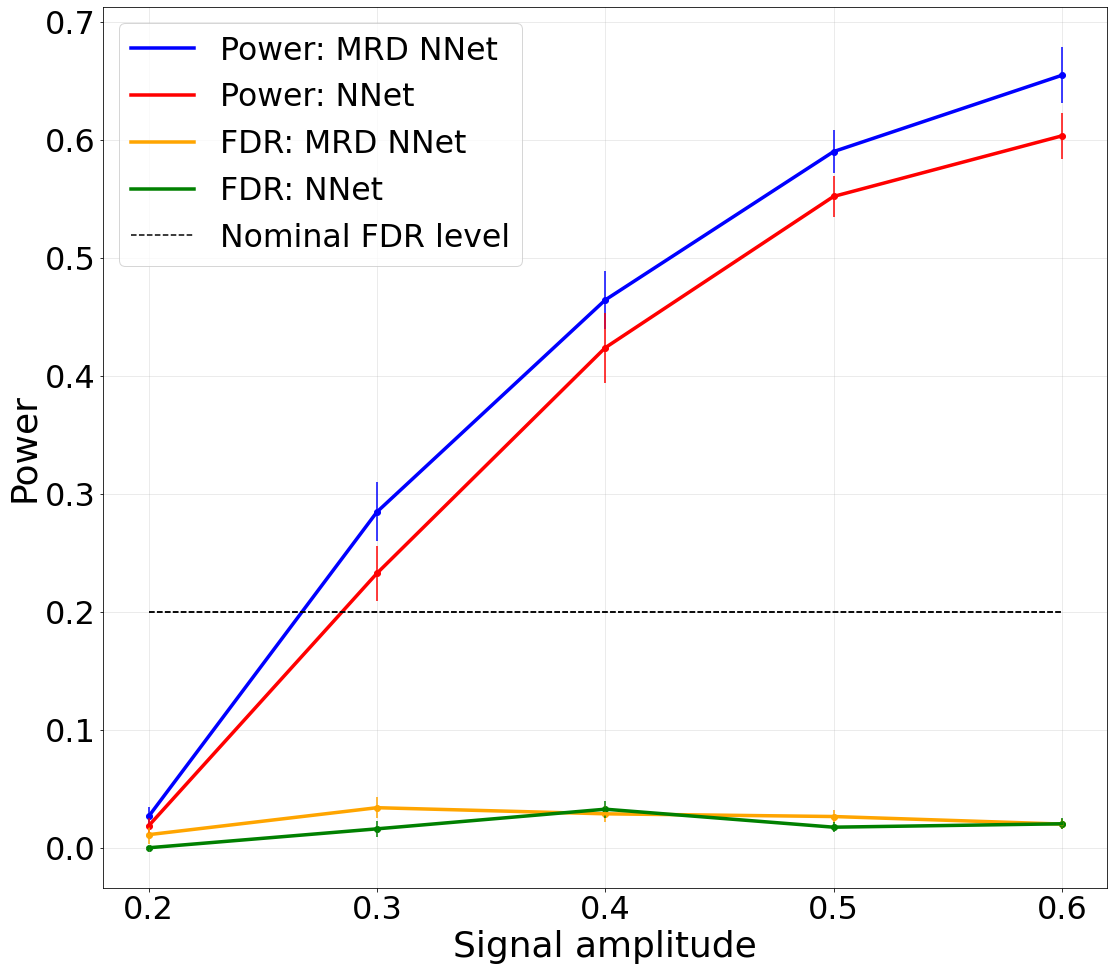

In [34]:
fz=36
fig, (ax3) = plt.subplots(1,1,sharey=False,figsize=(18,0.9*18))#,gridspec_kw = {'wspace':0.015})
l1=[];l2=[];l3=[]
    
l3+=ax3.plot(signal_strength, pow_NN_T, color='blue', label='Power: MRD NNet',linewidth=lw)
ax3.scatter(signal_strength, pow_NN_T, color='blue')
ax3.errorbar(signal_strength,pow_NN_T,yerr=sem_NN_T,color='blue', linestyle="None")

    
l3+=ax3.plot(signal_strength, pow_NN, color='red', label='Power: NNet',linewidth=lw)
ax3.scatter(signal_strength, pow_NN, color='red')
ax3.errorbar(signal_strength,pow_NN,yerr=sem_NN,  color='red',linestyle="None")

    




    
l3+=ax3.plot(signal_strength, fdr_NN_T, color='orange',label="FDR: MRD NNet",linewidth=lw)
ax3.scatter(signal_strength, fdr_NN_T, color='orange')
ax3.plot(signal_strength, th * np.ones(len(signal_strength)), linestyle='dashed', color='black')
ax3.errorbar(signal_strength,fdr_NN_T,yerr=semf_NN_T, color='orange',linestyle="None")

    
l3+=ax3.plot(signal_strength, fdr_NN, color='green',label="FDR: NNet",linewidth=lw)
ax3.scatter(signal_strength, fdr_NN, color='green')
ax3.errorbar(signal_strength,fdr_NN,yerr=semf_NN, color='green',linestyle="None")

l3+=ax3.plot(signal_strength, th * np.ones(len(signal_strength)), linestyle='dashed', color='black',label="Nominal FDR level") 
# leg1=ax1.legend(l1,['Power: MRD','Power: Base Model','FDR: MRD','FDR: Base Model','Nominal FDR level'],fontsize=fz-3);
# leg3=ax3.legend(l1,['Power: MRD Model','Power: Base Model','FDR: Base Model','FDR: MRD Model','Nominal FDR level'],
#                 fontsize=fz-3,loc=(1.01,.8*.44));
ax3.legend(loc="upper left", fontsize=fz-4.5)
# ax2.legend(loc="upper right", fontsize=fz)


ax3.set_xticks(signal_strength)
ax2.set_xticks(signal_strength)
ax2.set_xlabel("Signal amplitude",fontsize=fz)
ax2.set_ylabel("FDR",fontsize=fz);
ax3.set_xlabel("Signal amplitude",fontsize=fz)
ax3.set_ylabel("Power",fontsize=fz);
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4)
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4)
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(fz-4) 

ax2.grid(alpha=0.3)

ax3.grid(alpha=0.3)

ax2.set_ylim(0,0.5)

# for ax in fig.get_axes():
#     ax.label_outer()

# fig.savefig('C:\\Users\\admin2.EEM-642\\Desktop\\Research\\results\\figs\\interaction_NN_new.png', format='png', dpi=300,bbox_inches = 'tight');
fig.savefig('C:\\Users\\admin2.EEM-642\\Desktop\\interaction_NN_BY_1fig.png', format='png', dpi=300,bbox_inches = 'tight');


# BH analysis

In [111]:
###################### Power to a constant target FDR level #################
from scipy.stats import sem
import pandas as pd
from os import listdir
from os.path import isfile, join
import ast
lw=3.5
th=0.2
fz=29
load = True
dcrt=False
cnt=0; cnt_t=0
thh=0.05
# load = False
is_NN = True #'''TODO: fill in whether you produced NN p-vals or not'''
if load:
    signal_strength=[]
    source = 'C:\\Users\\admin2.EEM-642\\Desktop\\Research\\results\\from_server\\results_non_linear\\best_non_linear\\results_non_linear_lmda10.00_rho1.00_150321'#'''TODO: fill in the directory path'''
    list_files = [join(source, f) for f in listdir(source) if isfile(join(source, f))]
    p_vals_T = {}; p_vals_0 = {}; p_vals_ET = {}; p_vals_E = {}; 

    for file in list_files:
        if not 'csv' in file:
            continue
#         print(file)
        df = pd.read_csv(file)
        c= df['c'][0]
        seed= df['seed'][0]
        ones=df['ones'][0].replace('\n',',').replace('.',',').replace(',,',',')
        ones=np.array(ast.literal_eval(ones))
        if c!=0.12 or seed >= 100:
            continue

        p_vals_T[seed] = ast.literal_eval(df['p_vals_T'][0])
        p_vals_0[seed] = ast.literal_eval(df['p_vals_0'][0])
        p_vals_ET[seed] = ast.literal_eval(df['p_vals_ET'][0])
        p_vals_E[seed] = ast.literal_eval(df['p_vals_E'][0])


In [112]:
d=len(p_vals_T[1])
seeds_len = len(p_vals_T.keys())
p_T = np.zeros(d)
p_0 = np.zeros(d)
p_E = np.zeros(d)
p_ET = np.zeros(d)
for i in range(d):
    for seed in range(seeds_len):
        p_T[i] += p_vals_T[seed][i]
        p_0[i]  += p_vals_0[seed][i]
        p_E[i]  += p_vals_E[seed][i]
        p_ET[i] += p_vals_ET[seed][i]
for i in range(d):
    p_T[i] /= seeds_len
    p_0[i]  /= seeds_len
    p_E[i]  /= seeds_len
    p_ET[i] /= seeds_len

(array([ 1.,  6.,  6.,  9., 12., 14.,  8.,  8.,  3.,  3.]),
 array([0.65182817, 0.66549451, 0.67916084, 0.69282717, 0.70649351,
        0.72015984, 0.73382617, 0.74749251, 0.76115884, 0.77482517,
        0.78849151]),
 <BarContainer object of 10 artists>)

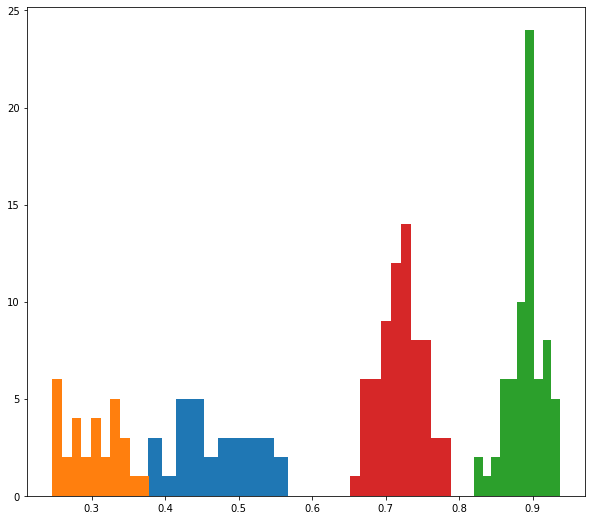

In [116]:
nulls = np.array([i for i in range(d) if i not in ones.nonzero()[0]],dtype='int64')
imps = ones.nonzero()[0]
fig, (ax) = plt.subplots(1,1,sharey=False,figsize=(10,0.9*10))

ax.hist(p_0[imps],bins=10)
ax.hist(p_T[imps],bins=10)

ax.hist(p_0[nulls],bins=10)
ax.hist(p_T[nulls],bins=10)


In [12]:
eur = 3.6
usd = 3.2
flight = 150 * usd
ski = 200 * eur
transport = 500 * eur
misc = 2000
apart = 4000
flight * 4 + ski * 2 + transport + apart + misc

11160.0